## Imports

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from skimage import io, transform
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings("ignore")

plt.ion() 

## Pre-process data

In [2]:
train_path = './data/cars_train/'
test_path = './data/cars_test/'
devkit_path = './data/cars_devkit'

train_annos_path = devkit_path + '/cars_train_annos.csv'
test_annos_path = devkit_path + '/cars_test_annos.csv'
cars_meta_path = devkit_path + '/cars_meta.csv'

In [3]:
train_annos = pd.read_csv(train_annos_path, header=None)
test_annos = pd.read_csv(test_annos_path, header=None)
cars_meta = pd.read_csv(cars_meta_path, header=None)

train_annos.columns = ['file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label']
test_annos.columns = ['file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label']
cars_meta.columns = ['label_details']
train_annos['label'] = train_annos['label']-1
test_annos['label'] = test_annos['label']-1

In [4]:
def label_details(row):
    index = row['label']
    return cars_meta.loc[index, 'label_details']

train_annos['label_details'] = train_annos.apply(lambda row: label_details(row), axis=1)
test_annos['label_details'] = test_annos.apply(lambda row: label_details(row), axis=1)

In [5]:
def rgb_images(data_path, df):
    for i, row in df.iterrows():
        file = row['file']
        image = Image.open(data_path + file)
        num_channel = len(image.split())
        if (num_channel != 3):
            df.loc[i, 'rgb'] = False
        else:
            df.loc[i, 'rgb'] = True
    df = df[df.rgb == True]
    df = df.drop('rgb', axis=1)
    return df

train_annos = rgb_images(train_path, train_annos)
test_annos = rgb_images(test_path, test_annos)

## Save pre-processed data 

In [6]:
train_annos.to_csv('train_annos_cleaned.csv', index=False)
test_annos.to_csv('test_annos_cleaned.csv', index=False)

## Create dataloader

In [7]:
class CarsDataset(Dataset):

    def __init__(self, annos_path, data_dir, transform=None):
        """
        Args:
            annos_path (string): Path to the csv file with annotations.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.car_details = pd.read_csv(annos_path)
        self.car_details = np.array(self.car_details)

        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.car_details)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.car_details[idx][0])
        image = Image.open(img_name)
        num_channel = len(image.split())
        car_class = self.car_details[idx][5]
        car_details = self.car_details[idx][6]
        x1, y1, x2, y2 = self.car_details[idx][1], self.car_details[idx][2], self.car_details[idx][3], self.car_details[idx][4]
        bounding_box = [x1, y1, x2, y2]

        if self.transform:
            image = self.transform(image)
     
        return image, bounding_box, car_class, car_details


## Visualize training data

In [8]:
train_annos.head()

file  bbox_x1  bbox_y1  bbox_x2  bbox_y2  label  \
0  00001.jpg       39      116      569      375     13   
1  00002.jpg       36      116      868      587      2   
2  00003.jpg       85      109      601      381     90   
3  00004.jpg      621      393     1484     1096    133   
4  00005.jpg       14       36      133       99    105   

                         label_details  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012

In [9]:
train_annos.describe(include='all')

file      bbox_x1      bbox_y1      bbox_x2      bbox_y2  \
count        8126  8126.000000  8126.000000  8126.000000  8126.000000   
unique       8126          NaN          NaN          NaN          NaN   
top     02277.jpg          NaN          NaN          NaN          NaN   
freq            1          NaN          NaN          NaN          NaN   
mean          NaN    64.955206   108.644721   638.257937   416.540364   
std           NaN    82.215563   104.591748   410.943033   273.889092   
min           NaN     1.000000     1.000000    76.000000    47.000000   
25%           NaN    19.000000    42.000000   392.000000   248.000000   
50%           NaN    39.000000    80.000000   569.000000   360.000000   
75%           NaN    79.000000   138.000000   746.000000   477.000000   
max           NaN  1648.000000  1508.000000  5205.000000  3389.000000   

              label        label_details  
count   8126.000000                 8126  
unique          NaN                  196  
top             NaN  GMC Savana Van 2012  
freq            NaN                   68  
mean      98.106325                  NaN  
std       56.449929                  NaN  
min        0.000000                  NaN  
25%       50.000000                  NaN  
50%       98.000000                  NaN  
75%      147.000000                  NaN  
max      195.000000                  NaN

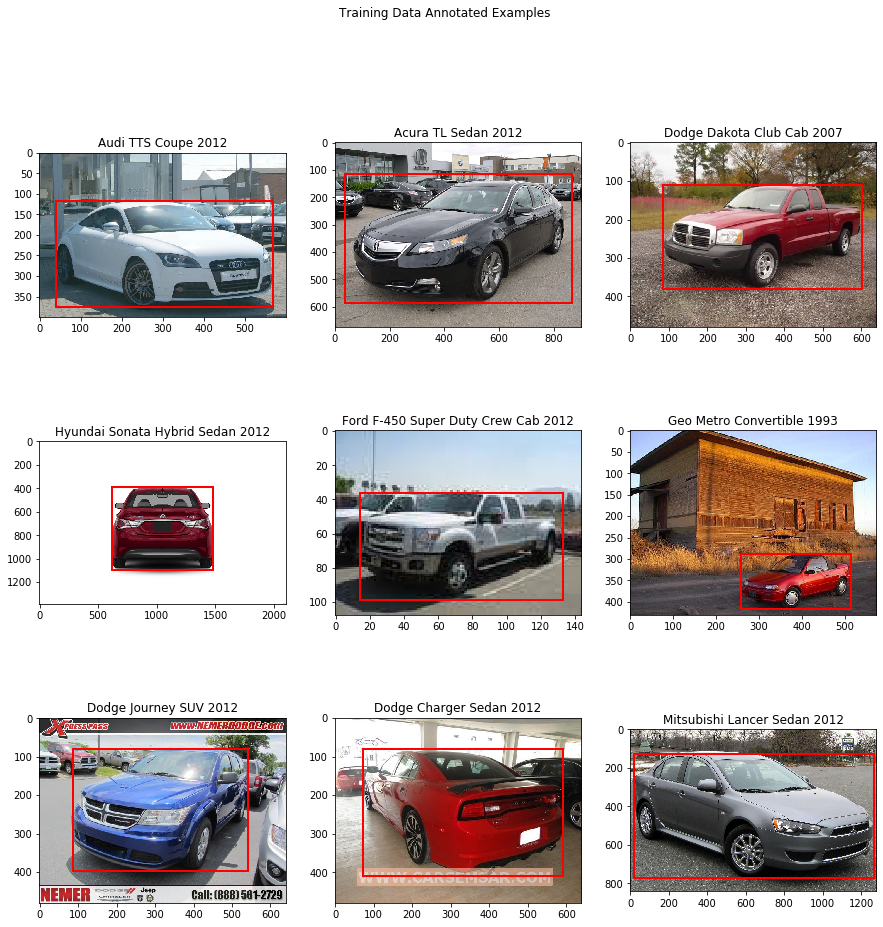

In [10]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path)

fig, axs = plt.subplots(3, 3, figsize=(15,15)) 
idx = 0
for i in range(3):
    for j in range(3):
        sample = cars_data_train[idx][0]
        box = cars_data_train[idx][1]
        title = cars_data_train[idx][3]

        xy = box[0], box[1]
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
        
        axs[i, j].imshow(sample)
        axs[i, j].set_title(title)
        axs[i, j].add_patch(rect)
        idx += 1
        
fig.suptitle("Training Data Annotated Examples")
plt.savefig("training_annotations_examples.png")

## Data distribution

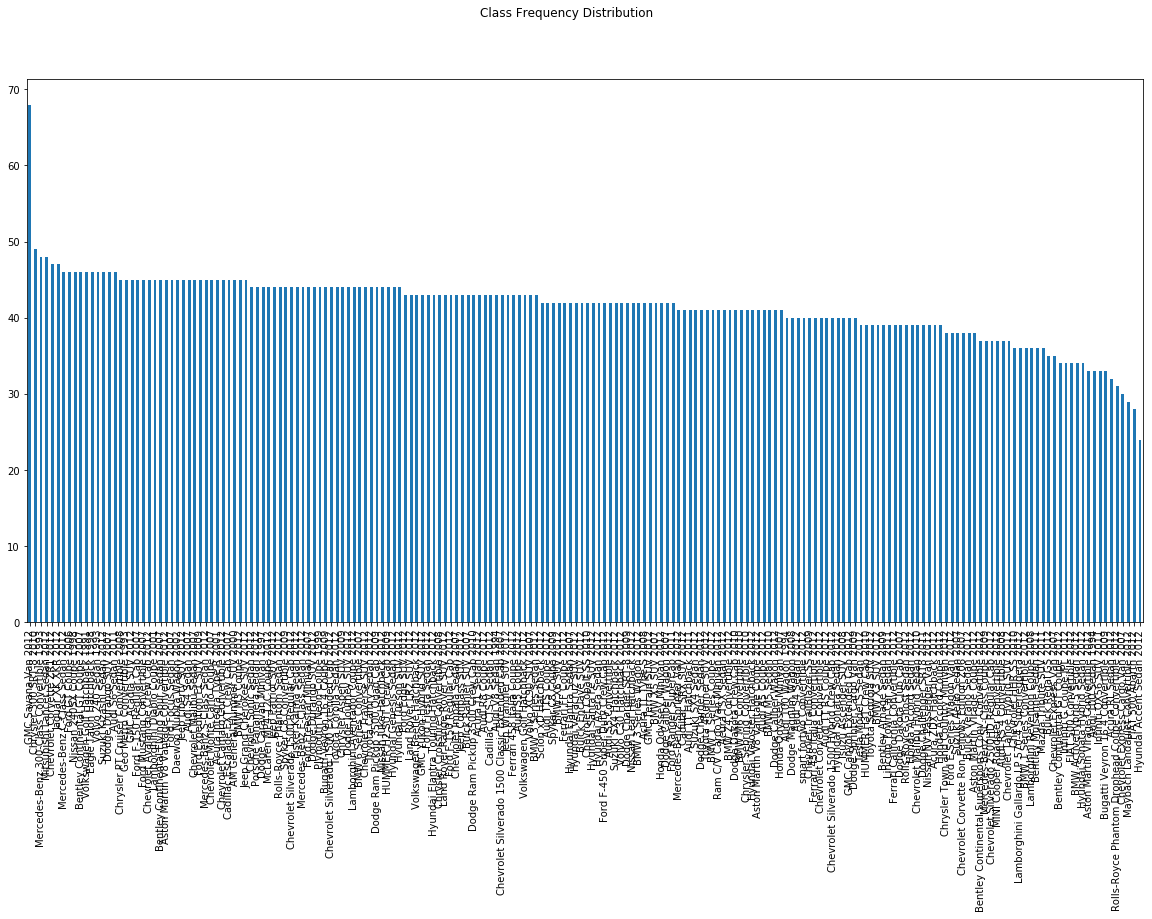

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
dataset = pd.read_csv('train_annos_cleaned.csv')
dataset['label_details'].value_counts().plot(ax=ax, kind='bar')

fig.suptitle("Class Frequency Distribution")
plt.savefig("class_frequency_distribution.png")

## Set up the ResNet model

In [12]:
def train_valid_split(train_dataset):
    
    percentages = [0.03, 0.10, 0.30, 1.00]
    np.random.random(2020)

    cars = {}
    
    for i in range(len(train_dataset)):
        label = train_dataset[i][2]
        if label in cars:
            cars[label].append(i)
        else:
            cars[label] = [i]

    subset_indices_valid = []
    for percentage in percentages: 
        subset_indices_train = []
        for car in cars:
            indices = cars[car]
            total = len(indices)
            np.random.shuffle(indices)
            subset_indices_train.extend(indices[:int(percentage * total)])
        np.save("train_indices_{}.npy".format(percentage), subset_indices_train)
    
    return subset_indices_train

create_splits = train_valid_split(cars_data_train)

In [15]:
def train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader):
    model.train()
    all_losses = []
    all_accuracies = []
    for epoch in range(n_epochs):
        losses = []
        correct = 0
        for i, data in enumerate(train_loader, 0):
            inputs, bbox, labels, details = data
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            correct += (labels==predicted).sum().item() 
        accuracy = 100/64*correct/len(train_loader)
        print("Epoch %s, Training Accuracy: %.4f %%, Training Loss: %.4f" % (epoch+1, accuracy, np.average(losses)))
        all_losses.append(np.average(losses))
        all_accuracies.append(accuracy)
    return all_losses, all_accuracies
   
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, bbox, labels, details = data
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    print('Test accuracy: %.4f %%' % (test_acc))
    return test_acc


## Run the model + vary the training data size

In [16]:
transform = transforms.Compose([transforms.Resize((300,300)), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path, transform=transform)
cars_data_test = CarsDataset('test_annos_cleaned.csv', test_path, transform=transform)

percentages = [0.03, 0.1, 0.3, 1.0]

for percentage in percentages:
    
    print("Using {} of total training data...".format(percentage))
    
    subset_indices_train = np.load("train_indices_{}.npy".format(percentage))

    train_loader = torch.utils.data.DataLoader(cars_data_train, batch_size=64, sampler=SubsetRandomSampler(subset_indices_train))
    test_loader = torch.utils.data.DataLoader(cars_data_test, batch_size=64)

    model_ft = models.resnet34(pretrained=True)
    num_ftrs = model_ft.fc.in_features

    model_ft.fc = nn.Linear(num_ftrs, 196)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')
    
    training_losses, training_accuracies = train_model(model_ft, criterion, optimizer, lrscheduler, 5, train_loader)
    test_accuracy = test_model(model_ft, test_loader)
    
    torch.save({
            'epoch': 5,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion': criterion,
            'lrscheduler': lrscheduler
            }, 'resnet34_{}.tar'.format(percentage))
    
    np.save("train_loss_{}.npy".format(percentage), training_losses)
    np.save("train_accuracy_{}.npy".format(percentage), training_accuracies)
    np.save("test_accuracy_{}.npy".format(percentage), test_accuracy)

Using 0.03 of total training data...
Epoch 1, Training Accuracy: 1.0417 %, Training Loss: 5.4836
Epoch 2, Training Accuracy: 2.0833 %, Training Loss: 5.1457
Epoch 3, Training Accuracy: 22.3958 %, Training Loss: 4.6498
Epoch 4, Training Accuracy: 58.3333 %, Training Loss: 4.0862
Epoch 5, Training Accuracy: 85.9375 %, Training Loss: 3.4865
Test accuracy: 2.5794 %
Using 0.1 of total training data...
Epoch 1, Training Accuracy: 0.3906 %, Training Loss: 5.4617
Epoch 2, Training Accuracy: 13.0208 %, Training Loss: 4.7199
Epoch 3, Training Accuracy: 44.6615 %, Training Loss: 3.8783
Epoch 4, Training Accuracy: 72.2656 %, Training Loss: 3.0611
Epoch 5, Training Accuracy: 87.6302 %, Training Loss: 2.2700
Test accuracy: 11.0903 %
Using 0.3 of total training data...
Epoch 1, Training Accuracy: 1.7736 %, Training Loss: 5.2515
Epoch 2, Training Accuracy: 20.0591 %, Training Loss: 3.9712
Epoch 3, Training Accuracy: 53.2517 %, Training Loss: 2.6917
Epoch 4, Training Accuracy: 78.4206 %, Training Loss:

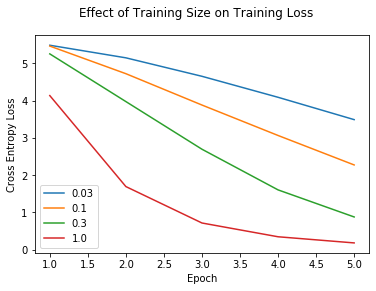

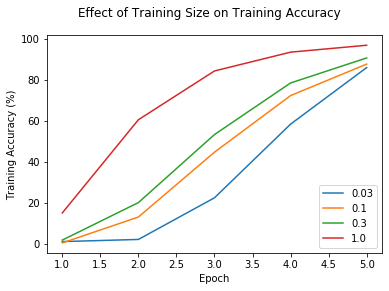

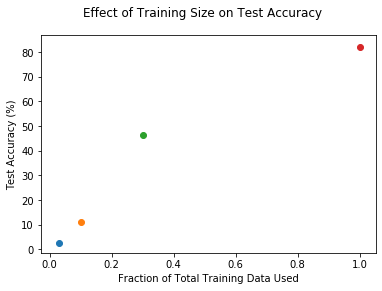

In [21]:
percentages = [0.03, 0.1, 0.3, 1.0]

fig = plt.figure()
for percentage in percentages:
    plt.plot([1,2,3,4,5], np.load("train_loss_{}.npy".format(percentage)), label=percentage)
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    
plt.legend(loc='lower left')
fig.suptitle("Effect of Training Size on Training Loss")
plt.savefig("training_size_training_loss.png")
    
fig = plt.figure()
for percentage in percentages:
    plt.plot([1,2,3,4,5], np.load("train_accuracy_{}.npy".format(percentage)), label=percentage)   
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy (%)")

plt.legend(loc='lower right')
fig.suptitle("Effect of Training Size on Training Accuracy")
plt.savefig("training_size_training_accuracy.png")

fig = plt.figure()
for percentage in percentages:
    plt.scatter(percentage, np.load("test_accuracy_{}.npy".format(percentage)))   
    plt.xlabel("Fraction of Total Training Data Used")
    plt.ylabel("Test Accuracy (%)")

fig.suptitle("Effect of Training Size on Test Accuracy")
plt.savefig("training_size_test_accuracy.png")
  

In [34]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 196)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')

checkpoint = torch.load('resnet34_1.0.tar')
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Visualize the model's correct predictions

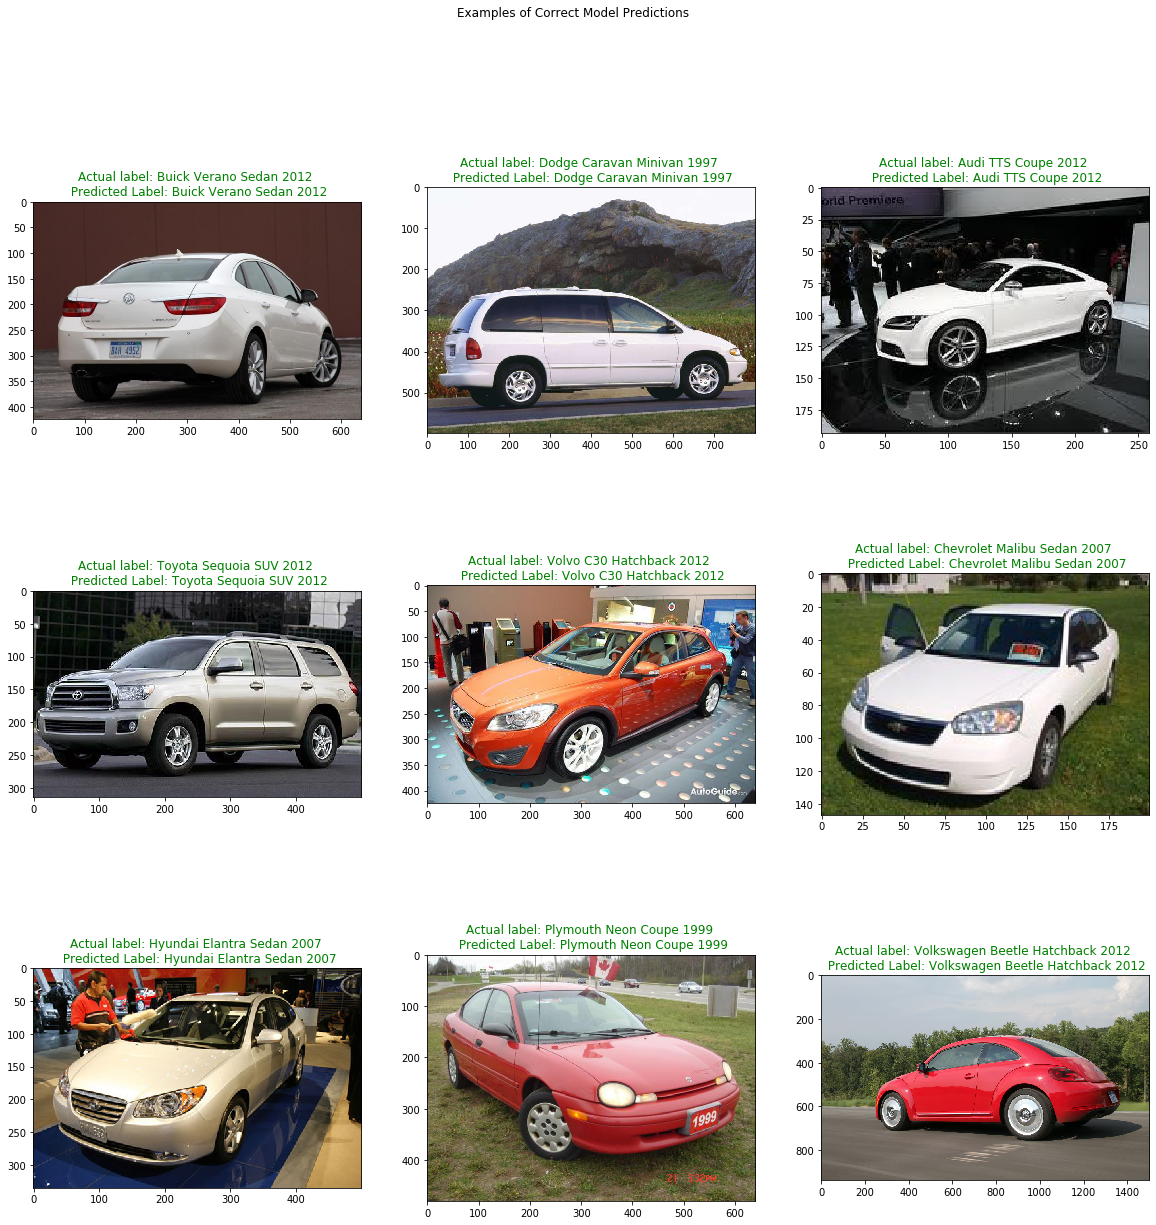

In [41]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path)
cars_meta = pd.read_csv(cars_meta_path, header=None)

fig, axs = plt.subplots(3, 3, figsize=(20,20)) 
idx = 10
i, j = 0, 0
while (i < 3 and j < 3):
    image = cars_data_train[idx][0]
    sample = image
    actual = cars_data_train[idx][3]
    sample = transform(sample)
    sample = torch.autograd.Variable(sample)
    sample = sample.unsqueeze(0)
    output = model_ft(sample)
    conf, pred = torch.max(output.data, 1)
    pred = pred.item()
    pred = cars_meta.loc[pred, 0]
    if (pred == actual):
        c = 'g'
        axs[i, j].imshow(image)
        axs[i, j].set_title('Actual label: {} \n Predicted Label: {}'.format(actual, pred), fontdict = {'color': c})
        if (i >= 2):
            i = 0
            j += 1
        else:
            i += 1
    idx += 1
     
fig.suptitle("Examples of Correct Model Predictions")
plt.savefig("correct_predictions_grid.png")

## Visualize the model's incorrect predictions

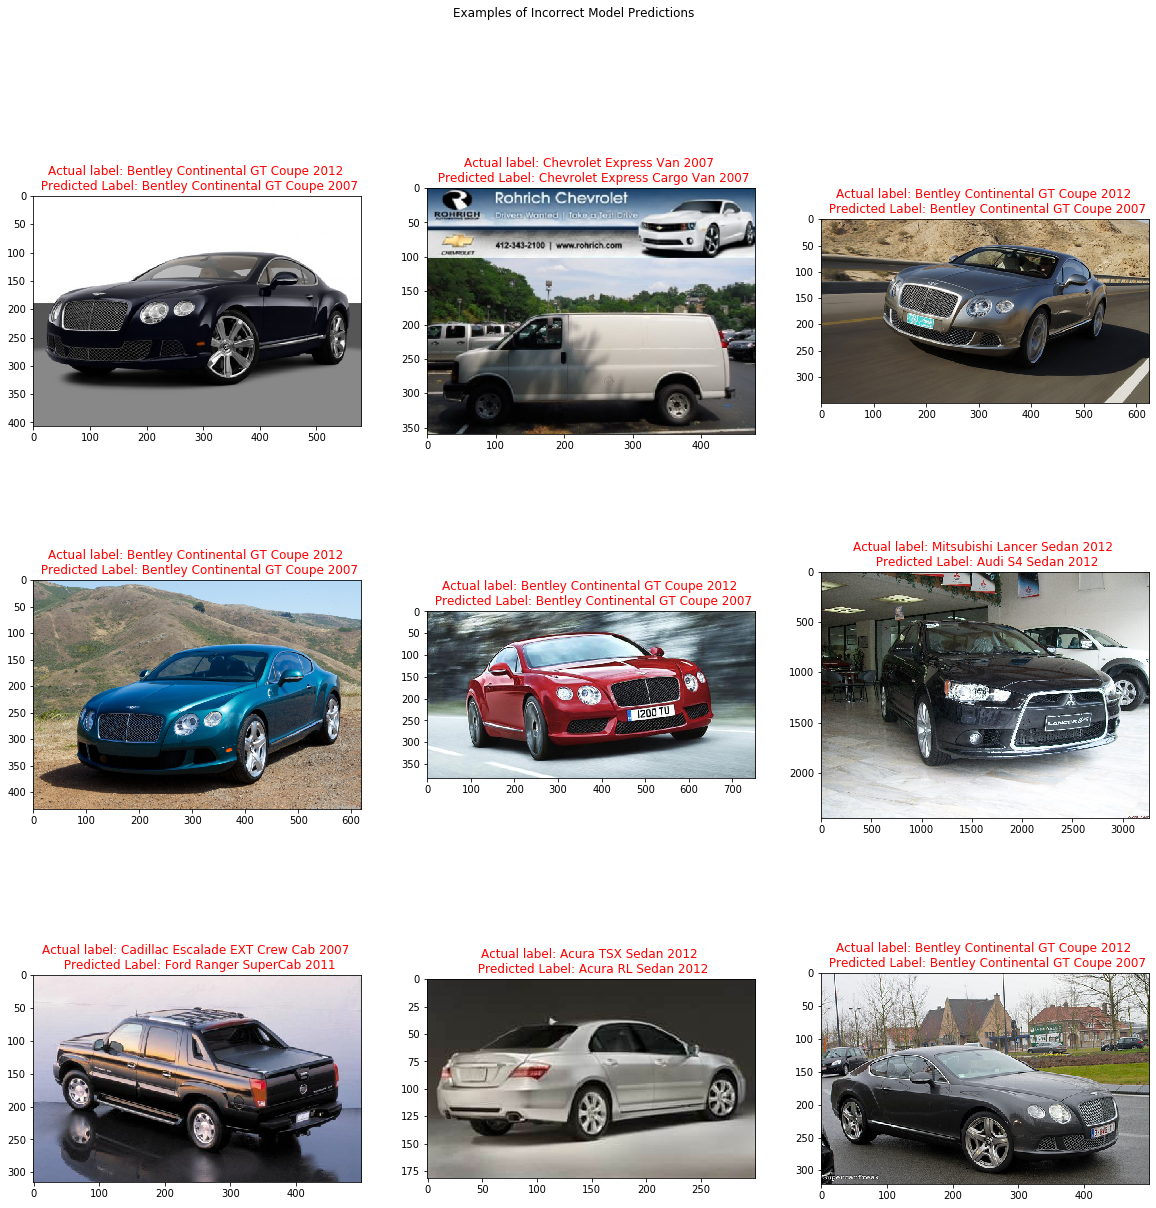

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(20,20)) 
idx = 10
i, j = 0, 0
while (i < 3 and j < 3):
    image = cars_data_train[idx][0]
    sample = image
    actual = cars_data_train[idx][3]
    sample = transform(sample)
    sample = torch.autograd.Variable(sample)
    sample = sample.unsqueeze(0)
    output = model_ft(sample)
    conf, pred = torch.max(output.data, 1)
    pred = pred.item()
    pred = cars_meta.loc[pred, 0]
    if (pred != actual):
        c = 'r'
        axs[i, j].imshow(image)
        axs[i, j].set_title('Actual label: {} \n Predicted Label: {}'.format(actual, pred), fontdict = {'color': c})
        if (i >= 2):
            i = 0
            j += 1
        else:
            i += 1
    idx += 1
     
fig.suptitle("Examples of Incorrect Model Predictions")
plt.savefig("incorrect_predictions_grid.png")

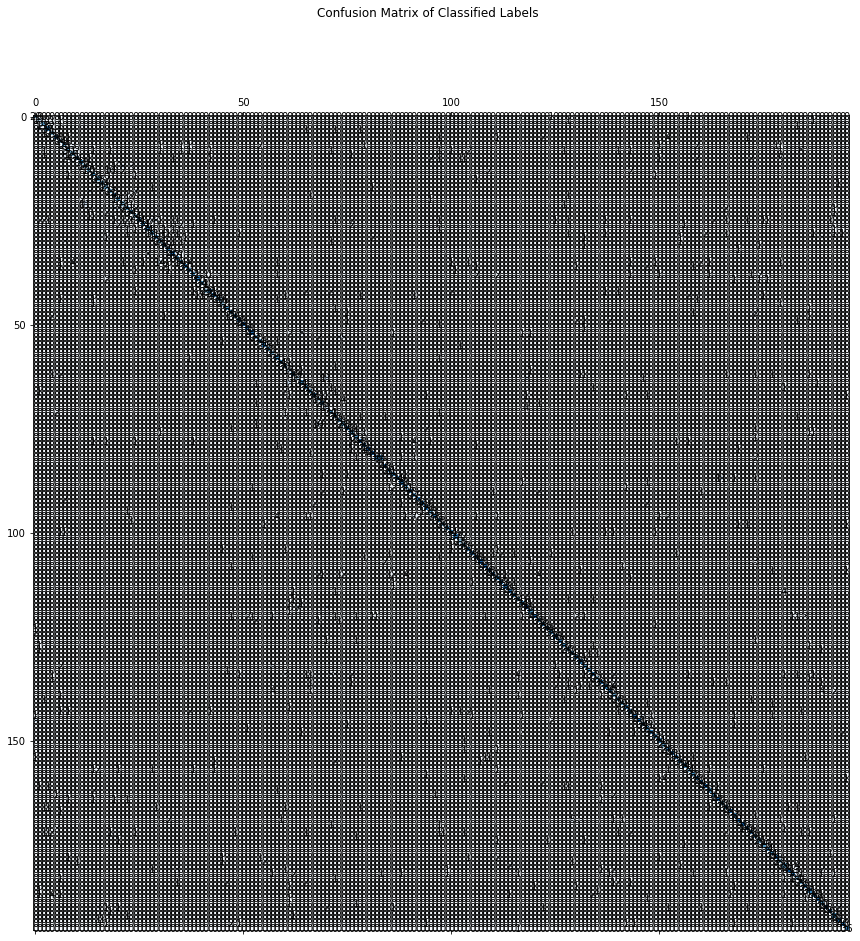

In [43]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_helper(model, test_loader):
    model.eval()  
    images = []
    prediction = []
    ground_truth = []
    with torch.no_grad():   
        for i, data in enumerate(test_loader, 0):
            inputs, bbox, labels, details = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            prediction.extend(predicted)
            ground_truth.extend(labels)
    return prediction, ground_truth

prediction, ground_truth = confusion_matrix_helper(model_ft, test_loader)

plot = confusion_matrix(prediction, ground_truth)

fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(plot, cmap=plt.cm.Blues)
for i in range(196):
    for j in range(196):
        c = plot[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
fig.suptitle("Confusion Matrix of Classified Labels")
plt.savefig("confusion_matrix.png")

## More correct predictions visualized (individually)

In [48]:
num = 3000
for i in range(len(cars_data_train)):
    idx = i
    image = cars_data_train[idx][0]
    sample = image
    actual = cars_data_train[idx][3]
    sample = transform(sample)
    sample = torch.autograd.Variable(sample)
    sample = sample.unsqueeze(0)
    output = model_ft(sample)
    conf, pred = torch.max(output.data, 1)
    pred = pred.item()
    pred = cars_meta.loc[pred, 0]
    if (pred != actual):
        continue
    else:
        if (num > 5):
            break
        c = 'c'
        fig = plt.figure()
        plt.imshow(image)
        print('test')
        num += 1
        fig.suptitle('Actual label: {} \n Predicted Label: {}'.format(actual, pred), fontdict = {'color': c})
        plt.savefig("correct{}.png".format(num))

## More incorrect predictions visualized (individually)

In [49]:
num = 3000
for i in range(len(cars_data_train)):
    idx = i
    image = cars_data_train[idx][0]
    sample = image
    actual = cars_data_train[idx][3]
    sample = transform(sample)
    sample = torch.autograd.Variable(sample)
    sample = sample.unsqueeze(0)
    output = model_ft(sample)
    conf, pred = torch.max(output.data, 1)
    pred = pred.item()
    pred = cars_meta.loc[pred, 0]
    if (pred == actual):
        continue
    else:
        if (num > 5):
            break
        c = 'r'
        fig = plt.figure()
        plt.imshow(image)
        num += 1
        fig.suptitle('Actual label: {} \n Predicted Label: {}'.format(actual, pred), fontdict = {'color': c})
        plt.savefig("incorrect{}.png".format(num))